In [129]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time

tqdm.pandas()

# Get data
train_data_small = pd.read_csv(r"MNIST_train_small.csv")
test_data_small = pd.read_csv(r"MNIST_test_small.csv")

In [ ]:
def custom_mode(object):
    modes = object.mode()
    # If modes is a Series, take the first value; if it's a single value, return it directly
    mode_value = modes.iloc[0] if isinstance(modes, pd.Series) else modes

    return mode_value


In [131]:
# Func to extract features and labels form dataset
def get_features_targets(data):

    targets= data.iloc[:, 0]
    features= data.iloc[:, 1:]
    features.columns = list(range(features.shape[1]))

    return features, targets

In [150]:
# Create KNN Classifier

class KNN:

    # Initialize Object
    def __init__(self, k, distance):
        if distance == 'l2':
            self.norm = 2
        self.features = None
        self.labels = None
        self.k = k

    # Fit to training set
    def fit(self, features, labels):
        self.features = features
        self.labels = labels

        
    # Prediction for one element
    def predict_one(self, x, mult=None):

        # start_time = time()
        distances = self.features.apply(lambda row: np.linalg.norm(row.sub(x), ord=self.norm), axis=1)
        # print(f"{time()-start_time}s taken to calculate all distances")
        distances = distances.sort_values().loc[distances!=0]
        

        if mult:

            # Output max neighbours in k list
            k_neighbours = distances[:np.max(self.k)].index
            k_neighbours_labels = self.labels.loc[k_neighbours]

            return np.array(k_neighbours_labels)
        
        else:
            k_neighbours = distances[:self.k].index
            k_neighbours_labels = self.labels.loc[k_neighbours]
            prediction_label = k_neighbours_labels.mode().iloc[0]

            return prediction_label
        
    def predict_one_g(self, x, mult=None):

        # start_time = time()
        distances = self.features.progress_apply(lambda row: np.linalg.norm(row.sub(x), ord=self.norm), axis=1)
        # print(f"{time()-start_time}s taken to calculate all distances")
        distances = distances.sort_values().loc[distances!=0]
        # print('Distances from each feature row to x', list(distances))
        

        if mult:

            # Output max neighbours in k list
            k_neighbours = distances[:np.max(self.k)].index
            k_neighbours_labels = self.labels.loc[k_neighbours]
            predicted_labels = []
            
            for i in self.k:
                # print('i=', i)
                # print('The current k_neighbours_labels looks like: (', list(k_neighbours_labels))
                # print(') with type ', type(k_neighbours_labels))        
                relevant_neighbours = pd.Series(list(k_neighbours_labels)[:i])
                # print('The relevant neighbours are ', relevant_neighbours)       
                predicted_k = custom_mode(relevant_neighbours)
                # print(f'The predicted label from {i} neighbors is ', predicted_k)
                predicted_labels.append(predicted_k)
                # print('all predicted labels update: ', predicted_labels)

            return predicted_labels
        
        else:
            k_neighbours = distances[:self.k].index
            k_neighbours_labels = self.labels.loc[k_neighbours]
            prediction_label = custom_mode(k_neighbours_labels)

            return prediction_label
    
    # Prediction for dataset
    def predict_g(self, x, mult=None):
        predictions = x.progress_apply(lambda row: self.predict_one_g(row, mult), axis=1)

        return predictions
    
    def predict(self, x, mult=None):
        predictions = x.progress_apply(lambda row: self.predict_one(row, mult), axis=1)

        return predictions

    # Error score
    def error_score(self, data_feature, data_label):
        predictions = self.predict(data_feature)
        errors = predictions.sub(data_label)
        error_score = len(errors.loc[errors!=0])/len(data_label)

        return error_score
    
    def error_score_g(self, predicted, data_label):
        difference = predicted.sub(data_label)
        error = len(difference.loc[difference!=0]) / len(data_label)

        return error
    
    # Error scores for multiple ks
    def error_mult(self, data_feat, data_labels):

        if isinstance(self.k, (np.ndarray, list)):
            predictions = self.predict(data_feat, mult=True)
            error_rates = []

            for i in self.k:
                predictions_k = predictions.apply(lambda x: pd.Series(x[:i]).mode()[0])
                errors = predictions_k.sub(data_labels)
                error_score = len(errors.loc[errors!=0])/len(data_labels)
                error_rates.append(error_score)
                
            return error_rates
            
        else:
            print("This method is used for multiple K")
            pass
        
    def error_mult_g(self, predicted, data_labels):

        if isinstance(self.k, (np.ndarray, list)):
            
            differences = [pr.sub(data_labels) for pr in predicted]
            errors = [len(d.loc[d!=0]) / len(d) for d in differences]
                
            return errors
            
        else:
            print("This method is used for multiple K")
            pass
        
    def loocv(self):
        k_list = self.k
        big_data_x = self.features.copy()
        big_data_y = self.labels.copy()
        loocv_errors = np.zeros(len(k_list))
        
        for i in range(len(self.features)):
            big_data_x_copy = big_data_x.copy()
            big_data_y_copy = big_data_y.copy()
            
            current_data_x = big_data_x_copy.drop(index=i)
            current_data_y = big_data_y_copy.drop(index=i)
            
            validation_x = big_data_x_copy.loc[i]
            validation_y = big_data_y_copy.loc[i]
            # print('The value of y to be verified is ', validation_y)
            
            self.fit(current_data_x, current_data_y)
            
            current_predictions = self.predict_one_g(validation_x, True)
            
            loocv_err = np.array([int(pr != validation_y) for pr in current_predictions])
            
            loocv_errors = loocv_errors + loocv_err
            
        return loocv_errors / len(self.features)


In [133]:
# Get features and labels for datasets
train_small_X, train_small_y = get_features_targets(train_data_small)
test_small_X, test_small_y = get_features_targets(test_data_small)

In [134]:
# Create KNN instance
KNN_test = KNN(k=3, distance='l2')
KNN_test.fit(train_small_X, train_small_y)

In [135]:
# Test working on small subset
train_small_now = train_small_X[:10]
predictions = KNN_test.predict(train_small_now)
print(predictions)

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

0    3
1    4
2    3
3    1
4    3
5    6
6    8
7    4
8    0
9    1
dtype: int64


In [136]:
train_y_now = train_small_y[:10]
print(train_y_now)

# Error score test with small data
print(KNN_test.error_score(train_small_now, train_y_now))

0    3
1    9
2    3
3    1
4    3
5    6
6    8
7    4
8    0
9    1
Name: 6, dtype: int64


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

0.1


In [137]:
k_list = np.array([i for i in range(1,20)])
KNN_mult = KNN(k=k_list, distance='l2')
KNN_mult.fit(train_small_X, train_small_y)

In [138]:
# errors_training = KNN_mult.error_mult(train_small_X, train_small_y)
# print(errors_training)

In [139]:
# errors_testing = KNN_mult.error_mult(test_small_X, test_small_y)
# print(errors_testing)

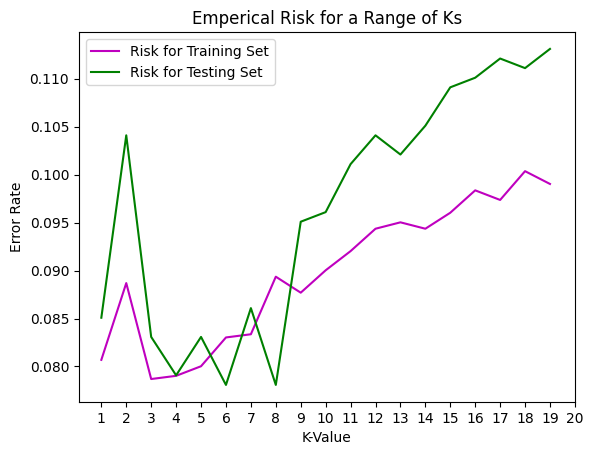

In [140]:
import matplotlib.pyplot as plt

plt.plot(k_list, errors_training, color='m', label='Risk for Training Set')
plt.plot(k_list, errors_testing, color='g', label='Risk for Testing Set')
plt.title('Emperical Risk for a Range of Ks')
plt.ylabel('Error Rate')
plt.xlabel('K-Value')
plt.xticks(list(range(1,21)))
plt.legend()
plt.show()

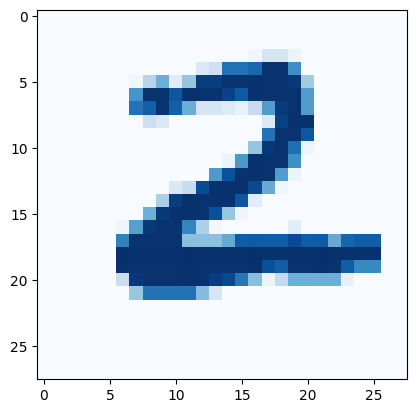

7


: 

In [ ]:
for i in range(1):
    plt.imshow(test_small_X.iloc[i].values.reshape(28,28), cmap='Blues')
    plt.show()
    
print(test_small_y.iloc[43])

In [142]:
# # Leave One Out Cross Validation
# k = 3
# k_list = list(range(1, 21))

# KNN_LOOCV = KNN(k, 'l2')

# # Obtain a large number of datasets where each itteration one entry is left out
# #errors_testing_LOOCV = []


# for i in range(len(train_small_X)):
#     t = train_small_X.copy()
#     learning = t[:i]+t[i+1:] 
#     validation = t[i]
#     print(learning)
#     print(validation)
    
#     labels_learning = t[:i]+t[i+1:]
#     target = t[i]
    
#     KNN_LOOCV.fit(learning, validation)
#     prediction = KNN_LOOCV.predict_one(validation)
#     print(prediction, target)
    
#     #errors_testing_LOOCV.append(KNN_LOOCV.error_score(validation, target))
    

    

In [153]:
# LOOCV for the small data set

train_small_X, train_small_y = get_features_targets(train_data_small)

# train_small_X = train_small_X[:30]
# train_small_y = train_small_y[:30]

k_list = list(range(1, 21))

KNN_LOOCV = KNN(k_list, 'l2')
KNN_LOOCV.fit(train_small_X, train_small_y)

loocv_small = KNN_LOOCV.loocv()

print('The errors for each k are given by ', loocv_small)

100%|██████████| 2998/2998 [00:00<00:00, 8389.11it/s]

The errors for each k are given by  [0.08072048 0.08872582 0.07871915 0.0790527  0.08005337 0.08305537
 0.08338893 0.08939293 0.08772515 0.09006004 0.09206137 0.09439626
 0.09506338 0.09439626 0.09606404 0.09839893 0.09739827 0.10040027
 0.09906604 0.10106738]


In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

train_small_X_binary = (train_small_X > 128).astype(int)

pca = PCA(n_components=50)
train_small_X_pca = pca.fit_transform(train_small_X_binary)

train_small_X_pca = pd.DataFrame(train_small_X_pca, index=train_small_X_binary.index)

KNN_LOOCV_preprocessed = KNN(k_list, 'l2')
KNN_LOOCV_preprocessed.fit(train_small_X_pca, train_small_y)

loocv_preprocessed = KNN_LOOCV_preprocessed.loocv()

print('LOOCV Error Rates after Preprocessing:', loocv_preprocessed)
plt.plot(k_list, loocv_small, label='Before Preprocessing', linestyle='dashed', marker='o', color='red')
plt.plot(k_list, loocv_preprocessed, label='After Preprocessing', linestyle='solid', marker='s', color='blue')

plt.xlabel('k-Value')
plt.ylabel('LOOCV Error Rate')
plt.title('Before vs After Preprocessing')
plt.legend()
plt.show()

NameError: name 'train_small_X' is not defined